# Demo de Deep Autoencoder (DAE) para procesar las imágenes de algunos TIPOS de Flores IRIS
Basado en: 

https://blog.keras.io/building-autoencoders-in-keras.html


https://towardsdatascience.com/deep-autoencoders-using-tensorflow-c68f075fd1a3

1) Importar librerías:

In [1]:
#@title Librerías a usar
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

print("\nLibrerías importadas")


Librerías importadas


2) Definir la configuración del modelo DAE:

In [2]:
## selección de los parámetros 

# 
#@markdown ### Parámetros de imágenes:
imagen_largo_ancho = 32 #@param {type:"integer"}
imagen_color = True #@param {type:"boolean"}

#@markdown ### Parámetros de la red:
rna_cant_neuronas_capas_ocultas = '392, 196, 84, 56, 32' #@param {type:"string"}
rna_cant_neuronas_features = 12 #@param {type:"integer"}
rna_cant_epocas_entrenamiento = 300 #@param {type:"integer"}


## aplicación de los parámetros elegidos

# tamaño de las imágenes
if imagen_largo_ancho<=10:
  imagen_largo_ancho = 10
IMAGE_SHAPE = (imagen_largo_ancho, imagen_largo_ancho, (3 if imagen_color else 1))

# cantidad de neuronas ocultas para features (datos comprimidos o codings)
num_features = (2 if rna_cant_neuronas_features<2 else rna_cant_neuronas_features)

# define tamaño de datos de entrada 
num_inputs = IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]
num_outputs = num_inputs

# cantidad de neuronas ocultas 
##hidden_layers = [ num_inputs//5, num_inputs//20, num_inputs//100 ]
dae_layers = []
for val in rna_cant_neuronas_capas_ocultas.split(','):
  dae_layers.append( int(val) )
      
#  agrega la capa de features a las capas
dae_layers.append( num_features ) 

# cantidad de neuronas ocultas para la parte Decoder 
#   (usa la la lista de Encoder inversa)
for eachEncLayer in dae_layers[0:len(dae_layers)-1][::-1]:
  dae_layers.append( eachEncLayer )

# cantidad de épocas del entrenamiento
cantEpocas = (100 if rna_cant_epocas_entrenamiento<1 else rna_cant_epocas_entrenamiento)

print("Configuración del DAE definida: [", num_inputs, dae_layers, num_outputs, "] ")

Configuración del DAE definida: [ 3072 [392, 196, 84, 56, 32, 12, 32, 56, 84, 196, 392] 3072 ] 


3) Montar el Drive:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demo IRIS/imagenes' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

Mounted at /content/gdrive


4) Cargar imágenes para entrenar el modelo DAE:

> Para Entrenamiento: 
- Clases cargadas:  24
- Imágenes cargadas:  24
- Ejemplo  versicolor   (32, 32, 3) : 


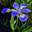



> Para Prueba: 
- Clases cargadas:  9
- Imágenes cargadas:  9
- Ejemplo  setosa   (32, 32, 3) : 


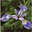

In [4]:
#@title Cargar Imágenes

# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = [] 
  images_ori = []
  esDA_ori = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir 
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:

            esImagDA = (each_imagFN[:2] == 'da')
            
            # abre la imagen
            imag = Image.open(auxiPath + "/" + each_imagFN)
            
            # ajusta el tamaño
            if IMAGE_SHAPE[2]==1:              
              tipoImage = 'L'
            else:                
              tipoImage = 'RGB'
            imag = imag.convert(tipoImage)
            imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.ANTIALIAS)          
            
            # transforma a un vector de nros
            arImag = np.array(imag)
            
            # agrega a los vectores
            classes_ori.append( each_dir )
            images_ori.append( arImag )
            esDA_ori.append( esImagDA )

  return classes_ori, images_ori, esDA_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train, esDAimag_train, tipoImage_train = cargarImagenes(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(classes_train))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )

# carga las imagenes de prueba
classes_test, images_test, esDAimag_test, tipoImage_test = cargarImagenes(imagPath_test)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(classes_test))
print("- Imágenes cargadas: ", len(images_test))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], tipoImage_test) )

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (24, 3072)


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (9, 3072)


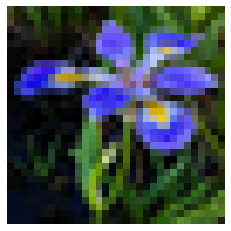

In [5]:
#@title Preparar imágenes

# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8))
    plt.gray()
  else:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE).astype(np.uint8))
  plt.axis("off")  

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):    
  auxiAr = np.array(imagList).astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), num_inputs))  
  return np.array(auxiAr)

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
x_test = prepare_imageList(images_test)

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
if len(x_train)>0:
  plot_image(x_train[0])

5) Creación del modelo DAE:

Modelo DAE creado con  13  capas:
Model: "DAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      [(None, 3072)]            0         
_________________________________________________________________
enc_1 (Dense)                (None, 392)               1204616   
_________________________________________________________________
enc_2 (Dense)                (None, 196)               77028     
_________________________________________________________________
enc_3 (Dense)                (None, 84)                16548     
_________________________________________________________________
enc_4 (Dense)                (None, 56)                4760      
_________________________________________________________________
enc_5 (Dense)                (None, 32)                1824      
_________________________________________________________________
features (Dense)             

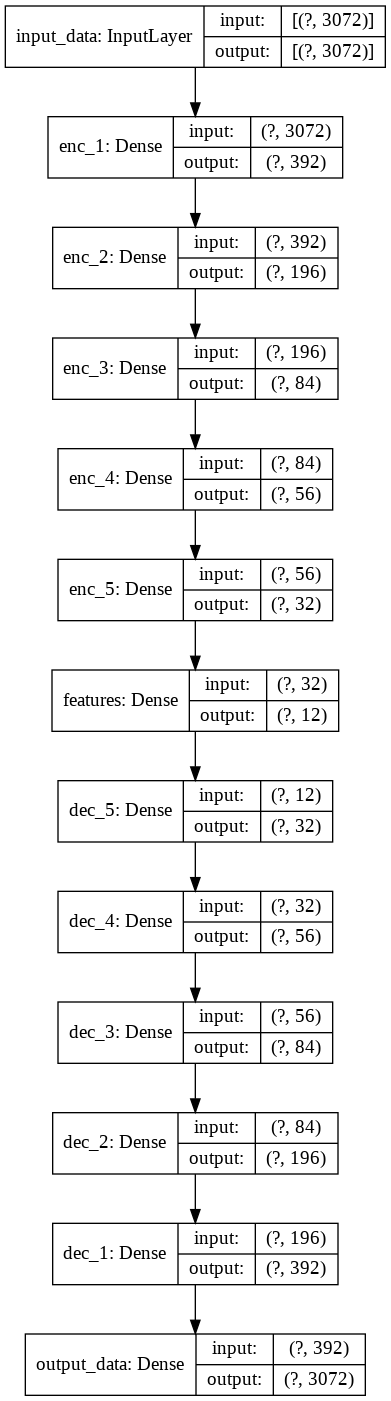

In [6]:
#@title Establecer el modelo
# define la arquitectura de capas del Deep Autoencoder
# teniendo en cuenta la definición dada anteriomente
input_data_Lay = Input(shape=(num_inputs,), name='input_data') # capa de entrada
eachLay = input_data_Lay
auxName = 'enc_'
auxId = 1 
for num_hid in dae_layers:  

    # define el nombre de la capa oculta
    if num_features==num_hid:
        auxlayerName = 'features'
        auxName = 'dec_'
        auxId = auxId - 1
    else:
        auxlayerName = auxName+str(auxId)
        if auxName == 'enc_':
          auxId = auxId + 1
        else:
          auxId = auxId - 1

    # agrega la capa oculta
    eachLay = Dense(num_hid, activation='relu', name=auxlayerName)(eachLay) # capas ocultas

    if num_features==num_hid:
      features_Lay = eachLay

##output_data_Lay = Dense(num_outputs, activation=None, name='output_data')(eachLay) # capa de salida
output_data_Lay = Dense(num_outputs, activation='sigmoid', name='output_data')(eachLay) # capa de salida

# genera el modelo Deep Autoencoder
DAEmodel = Model(input_data_Lay, output_data_Lay, name='DAE')
##DAEmodel.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
DAEmodel.compile(optimizer='adam', loss='binary_crossentropy')

print("Modelo DAE creado con ", len(DAEmodel.layers), " capas:")
DAEmodel.summary()
print("\n")
plot_model(DAEmodel, show_layer_names=True, show_shapes=True)

5) Entrenar el modelo DAE:

In [7]:
#@title Entrenar

# lleva a cabo el entrenamiento
# usando los mismos datos como entrada y salida
history = DAEmodel.fit(x_train, x_train,
                epochs = cantEpocas,
                shuffle=True)

Epoch 1/300
1/1 [==============================] - 0s 1ms/step - loss: 0.6932
Epoch 2/300
1/1 [==============================] - 0s 1ms/step - loss: 0.6930
Epoch 3/300
1/1 [==============================] - 0s 1ms/step - loss: 0.6927
Epoch 4/300
1/1 [==============================] - 0s 2ms/step - loss: 0.6922
Epoch 5/300
1/1 [==============================] - 0s 2ms/step - loss: 0.6904
Epoch 6/300
1/1 [==============================] - 0s 1ms/step - loss: 0.6853
Epoch 7/300
1/1 [==============================] - 0s 2ms/step - loss: 0.6751
Epoch 8/300
1/1 [==============================] - 0s 874us/step - loss: 0.6630
Epoch 9/300
1/1 [==============================] - 0s 2ms/step - loss: 0.6630
Epoch 10/300
1/1 [==============================] - 0s 1ms/step - loss: 0.6498
Epoch 11/300
1/1 [==============================] - 0s 777us/step - loss: 0.6441
Epoch 12/300
1/1 [==============================] - 0s 947us/step - loss: 0.6426
Epoch 13/300
1/1 [==============================] - 0s 

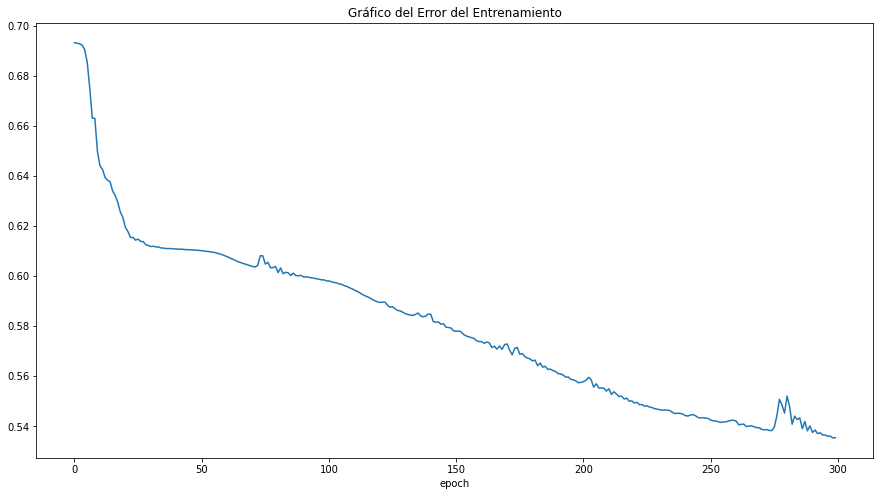

In [8]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8)) 
plt.plot(history.history['loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.show()


7) Evaluar el modelo DAE entrenado solicitando que reconstruya las imágenes ingresadas:

*** Resultados con datos de Entrenamiento: 
1/1 [==============================] - 0s 1ms/step - loss: 0.5347

>Evaluación del Modelo: 
    - Error:  0.5347484350204468



>Resultados: 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


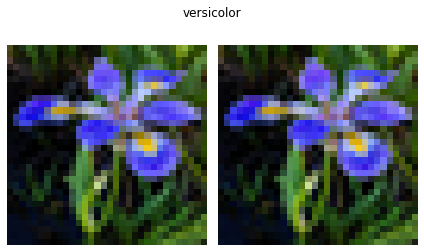

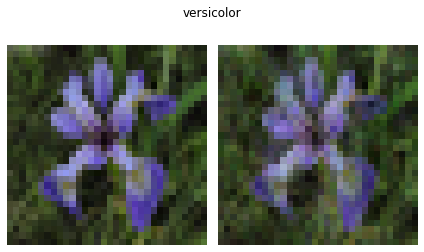

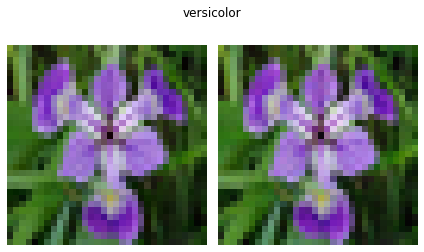

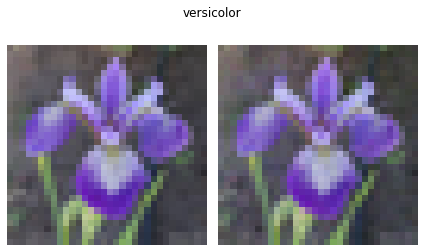

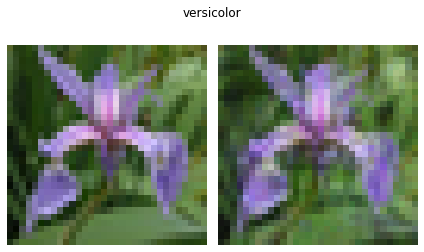

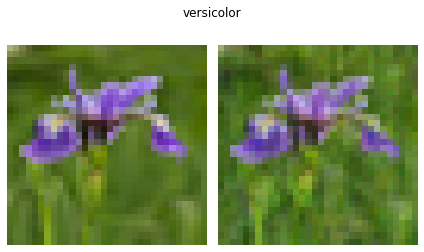

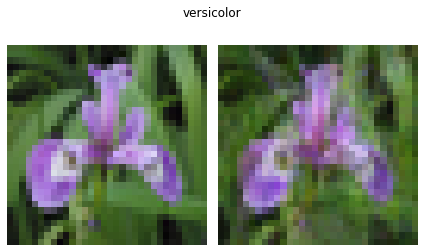

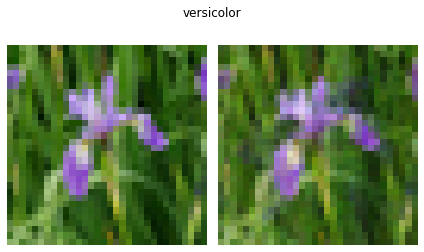

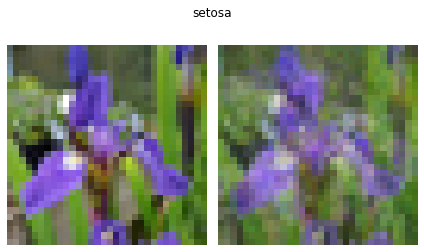

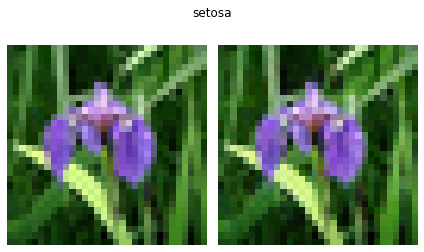

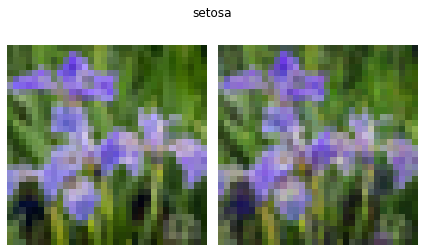

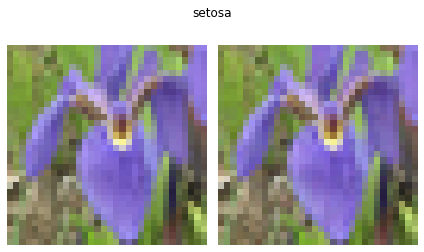

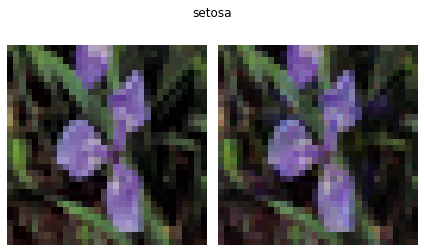

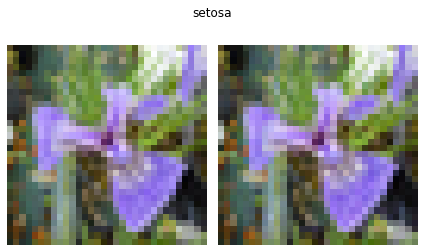

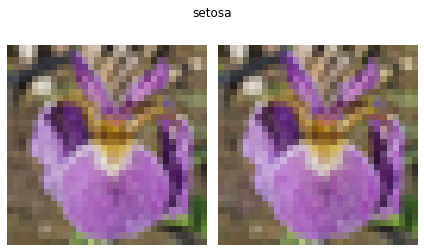

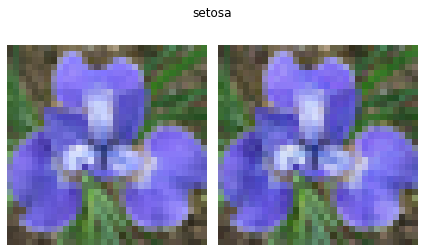

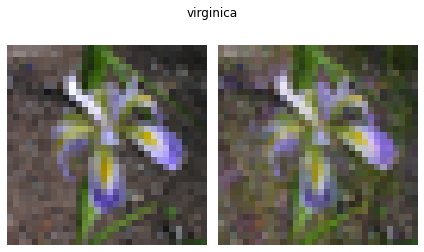

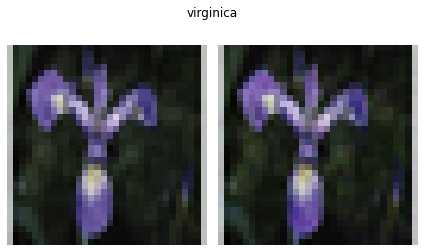

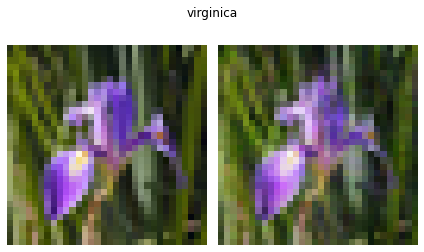

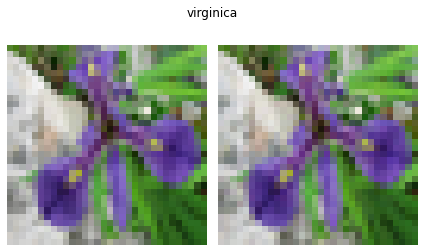

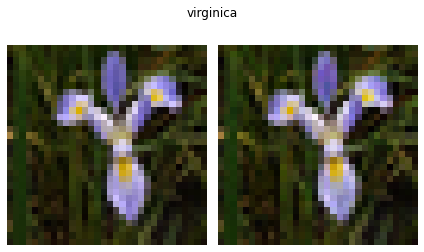

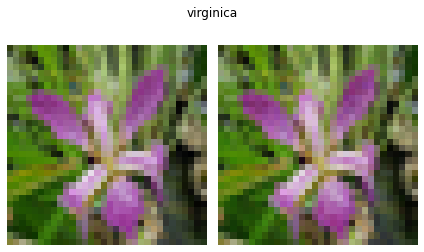

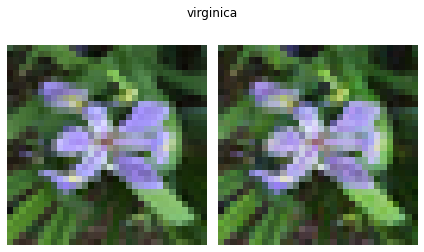

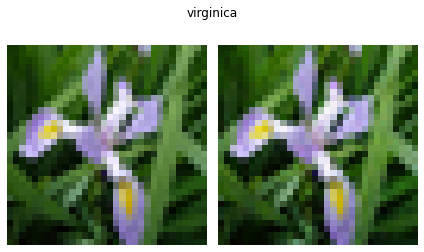

In [9]:
#@title Evaluar el modelo con las imágenes de entrenamiento

# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, cl, esDAimag):

  # evalua al modelo 
  resEval = DAEmodel.evaluate(x, x)
  print("\n>Evaluación del Modelo: ")
  print("    - Error: ", resEval)
  print("\n")

  # procesa las imágenes con el modelo 
  reconstr_imgs = DAEmodel.predict(x)

  # muestra las 15 primeras imágenes 
  print("\n>Resultados: ")
  for i in range(len(x)):
    # no muestra las generadas por DA
    if not esDAimag[i]:
          # prepara para mostrar
          fig = plt.figure()
          fig.suptitle(cl[i])

          # muestra la real
          ax1 = fig.add_subplot(121)
          plot_image(x[i])

          # muestra la generada por el modelo
          ax2 = fig.add_subplot(122)
          plot_image(reconstr_imgs[i])

          plt.tight_layout()
          fig = plt.gcf()


# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(x_train, classes_train, esDAimag_train)

9) Probar el modelo DAE entrenado con otras imágenes:

*** Resultados con datos de Prueba: 
1/1 [==============================] - 0s 2ms/step - loss: 0.6350

>Evaluación del Modelo: 
    - Error:  0.6350046992301941



>Resultados: 


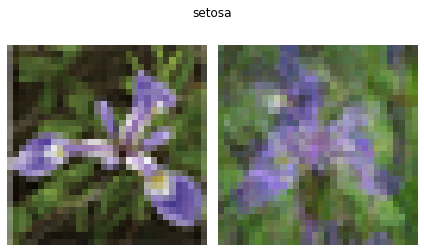

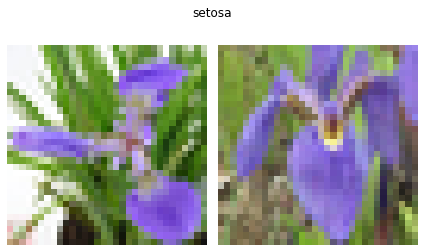

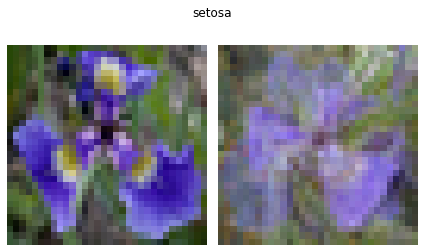

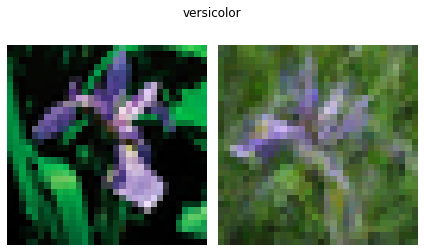

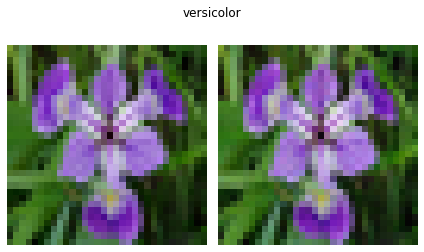

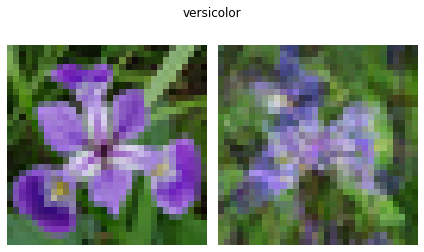

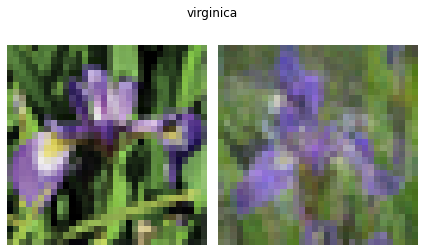

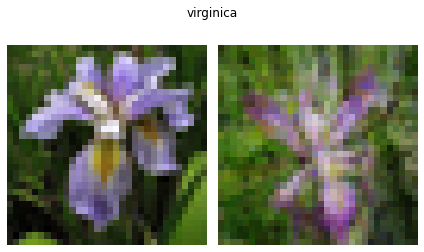

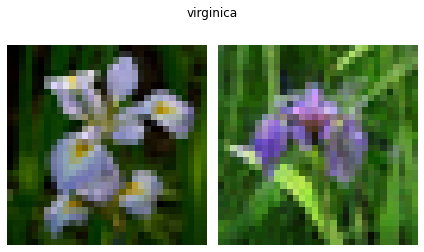

In [10]:
#@title Evaluar el modelo con las imágenes de prueba

# prueba con los datos de prueba
print("*** Resultados con datos de Prueba: ")
probarModelo(x_test, classes_test, esDAimag_test)

8) A partir del modelo DAE entrenado, generar dos sub-modelos Encoder y Decoder:


*   Generar y usar el modelo Encoder para 'clusterizar' las imágenes de entrenamiento:


> Modelo Encoder: 
Model: "Encoder/Clustering"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      [(None, 3072)]            0         
_________________________________________________________________
enc_1 (Dense)                (None, 392)               1204616   
_________________________________________________________________
enc_2 (Dense)                (None, 196)               77028     
_________________________________________________________________
enc_3 (Dense)                (None, 84)                16548     
_________________________________________________________________
enc_4 (Dense)                (None, 56)                4760      
_________________________________________________________________
enc_5 (Dense)                (None, 32)                1824      
_________________________________________________________________
features (Dense)             

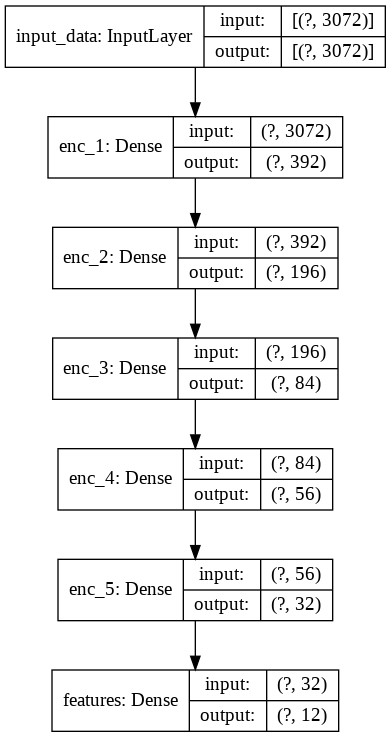

In [11]:
#@title Generar el sub-modelo Encoder para Clustering
## (desde input hasta features)

# reutiliza las capas entrenadas del modelo DAE original
clust_input_Lay = input_data_Lay  # capa de entrada
clust_output_Lay =  features_Lay  # capa de salida

# genera el modelo
CLUSTmodel = Model(input_data_Lay, features_Lay, name='Encoder/Clustering')

print("> Modelo Encoder: ")
CLUSTmodel.summary()
plot_model(CLUSTmodel, show_layer_names=True, show_shapes=True)



> Estadísticas de Clutering de Datos Originales codificado en  12  valores: 
- Mínimos:    [0.         0.36351994 0.         0.         0.         0.
 1.97227538 0.         0.         0.         4.21249533 0.        ]
- Máximos:    [20.95564079 31.70937729  0.         12.54628849  0.         36.94248581
 22.04429436 20.25242805  0.          0.         14.93529415 29.43325806]
- Totales:    [161.87947154 414.88710573   0.          40.27379608   0.
 338.61359036 320.58715165 307.25077122   0.           0.
 201.90544891 280.4232204 ]
- Promedios:  [ 6.74497798 17.28696274  0.          1.67807484  0.         14.1088996
 13.35779799 12.80211547  0.          0.          8.41272704 11.68430085]





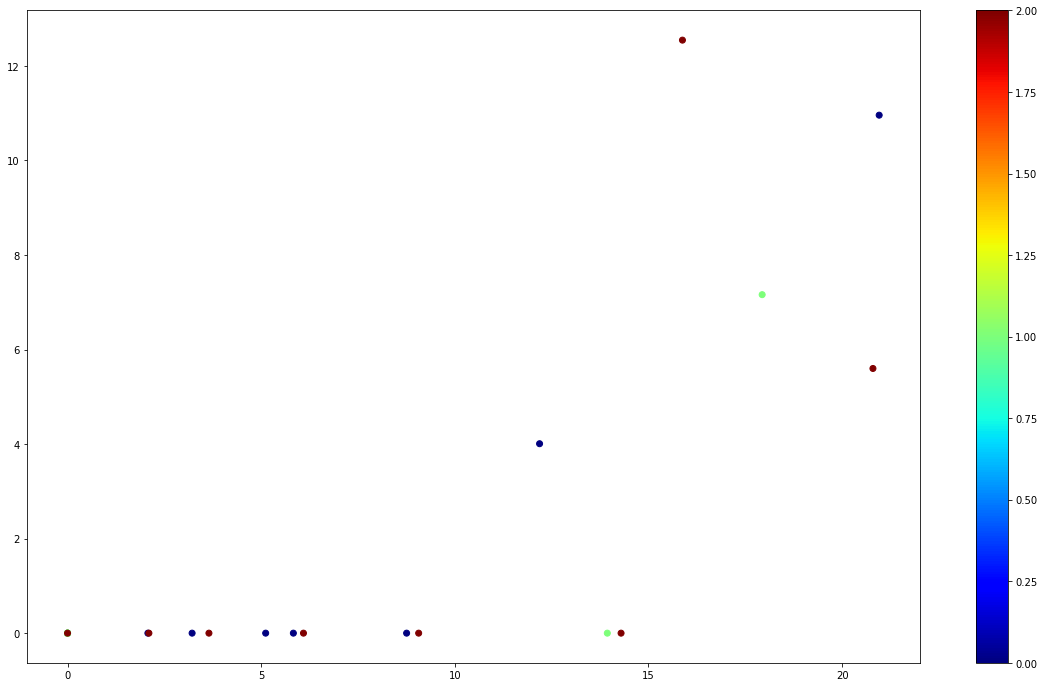


Donde: 
    0 :  versicolor
    1 :  setosa
    2 :  virginica


In [20]:
 #@title Generar Clustering
  # Muestra estadísticas y gráfico de los datos codificados

# determina datos a usar
usarDatos = 'Datos Entrenamiento' #@param ["Datos Entrenamiento", "Datos de Prueba"] {allow-input: false}
if usarDatos == 'Datos Entrenamiento':
  datosUsar_prep = x_train
  datosUsar_y = classes_train
else:
  datosUsar_prep = x_test
  datosUsar_y = classes_test

# filtra los datos a dos columnas para mostrar
feature_col1 =  0#@param {type:"integer"}
feature_col2 = 3 #@param {type:"integer"}


# genera matrix auxiliar para mostrar
CLASES = []
datosUsarNro_y = []
for y in datosUsar_y:
  if y in CLASES:
    aux = CLASES.index(y) 
  else:
    CLASES.append( y )
    aux = len(CLASES)-1
  datosUsarNro_y.append( aux )
     

# procesa los datos para recibir el valor codificado de cada una
x_encoded = CLUSTmodel.predict(datosUsar_prep)

# calcula estadisticas
minArClust = np.empty(num_features)
minArClust.fill(9999.99)
maxArClust = np.empty(num_features)
maxArClust.fill(-9999.99)
sumArClust = np.zeros(num_features)
for val in x_encoded:
  for i in range(num_features):
      sumArClust[i] = sumArClust[i]+val[i]
      if val[i]<minArClust[i]: 
          minArClust[i] = val[i]
      if val[i]>maxArClust[i]: 
          maxArClust[i] = val[i]
print("\n\n> Estadísticas de Clutering de Datos Originales codificado en ", num_features," valores: ")
print("- Mínimos:   ", minArClust)
print("- Máximos:   ", maxArClust)
print("- Totales:   ", sumArClust)
print("- Promedios: ", sumArClust/len(x_encoded))
print("\n\n")


# muestra el gráfico codificado 
plt.figure(figsize=(20, 12))
plt.scatter(x_encoded[:,feature_col1], x_encoded[:,feature_col2], c=datosUsarNro_y, cmap='jet')
plt.colorbar()
plt.show()

print("\nDonde: ")
for i in range(len(CLASES)):
    print("   ", i, ": ", CLASES[i] )

*   Generar y usar el modelo Decoder para generar nuevas imágenes similares a las entrenadas:

> Modelo Decoder: 
Model: "Decoder/Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_gen (InputLayer)       [(None, 12)]              0         
_________________________________________________________________
dec_5 (Dense)                (None, 32)                416       
_________________________________________________________________
dec_4 (Dense)                (None, 56)                1848      
_________________________________________________________________
dec_3 (Dense)                (None, 84)                4788      
_________________________________________________________________
dec_2 (Dense)                (None, 196)               16660     
_________________________________________________________________
dec_1 (Dense)                (None, 392)               77224     
_________________________________________________________________
output_data (Dense)          (

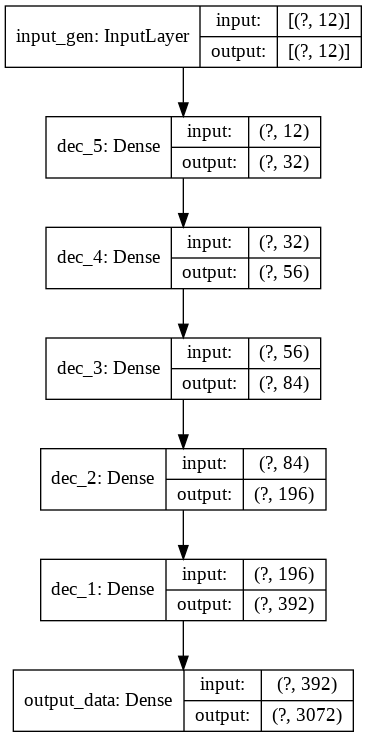

In [13]:
#@title Generar el sub-modelo Decoder para Generator
## (desde features hasta output)

# genera una copia del modelo DAE original para evitar romperlo
auxiCloneModel = keras.models.model_from_json(DAEmodel.to_json())
#auxiCloneModel.summary()

# genera la nueva estructura del Generator
input_gen = Input(shape=(num_features,), name='input_gen') # nueva capa de entrada
auxLay_gen = input_gen
for pos in range(len(DAEmodel.layers)):

  # obtiene el nombre de la capa actual
  auxName = DAEmodel.layers[pos].name  
  
  # sólo considera las capas luego de features (decoder y output)
  # para copiar los pesos del DAE original y actualizar la estrcutura
  if auxName.startswith('dec_') or auxName=='output_data':
    auxiCloneModel.layers[pos].set_weights(DAEmodel.layers[pos].get_weights()) 
    auxLay_gen = auxiCloneModel.layers[pos](auxLay_gen) 

# crea el nuevo modelo Generator
GENmodel = Model(input_gen, auxLay_gen, name = 'Decoder/Generator')

print("> Modelo Decoder: ")
GENmodel.summary()
plot_model(GENmodel, show_layer_names=True, show_shapes=True)


> Resultados: 


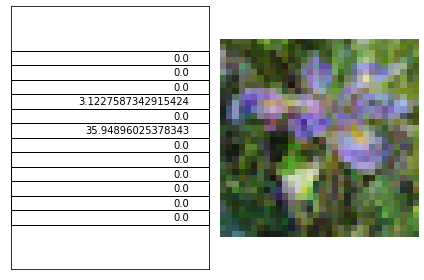

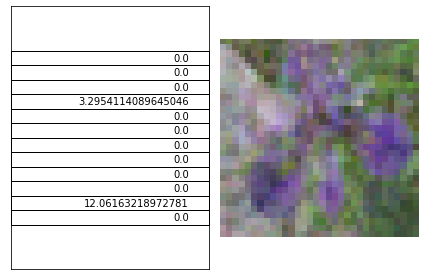

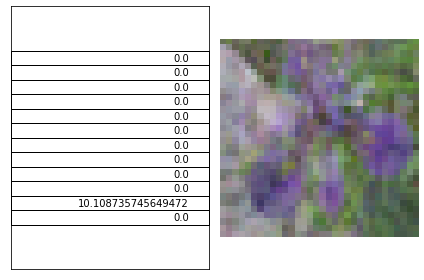

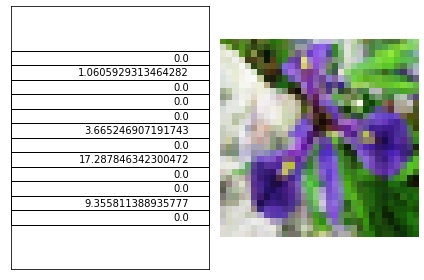

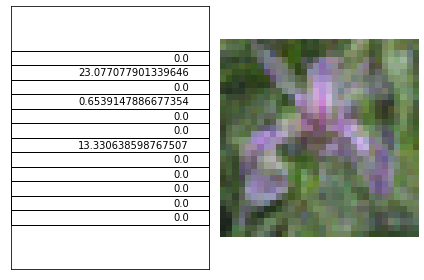

In [14]:
#@title Ejecutar el Generator
#  usando valores definidos al azar como datos de entrada
cantGenerar = 5 #@param {type:"integer"}

# genera los datos de entrada
# (como la codificación tiene varias posiciones con ceros 
# se considera que sólo se ponen al azar entre 10% y el 70% de los valores, el resto queda en cero,
# --sino se podría hacer con " np.random.rand(cantImagenGenerar, num_features) "-- )
arX = []
minRnd = 1
maxRnd = num_features
for i in range(cantGenerar):
  X = np.zeros(num_features)
  for j in range(np.random.randint(low=minRnd, high=maxRnd)):
      pos = np.random.randint(low=0, high=num_features-1)
      # si están definidas las estadisticas las usa, sino no
      if (minArClust is None or  maxArClust is None):
          X[pos] = np.random.uniform()    
      else:
          X[pos] = np.random.uniform(minArClust[pos], maxArClust[pos])              
      
  arX.append( X )


# ejecuta el modelo Generator
imagOut = GENmodel.predict( np.array(arX).reshape((len(arX), num_features)) )  
 
# muestra las imágenes generadas
print("\n> Resultados: ")
for i in range(len(arX)):

    fig = plt.figure()

    # muestra los datos
    ax1 = fig.add_subplot(121)
    datosMostrar = arX[i].reshape(num_features, 1) 
    ax1.table(cellText=datosMostrar, loc='center')   
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)  

    #  muestra reconstrucción
    ax2 = fig.add_subplot(122)
    plot_image(imagOut[i])  

    plt.tight_layout()
    fig = plt.gcf()


*   Combinar los resultados de los modelos Clustering y Generator para mostrar que funcionan juntos como el DAE original:


> Resultados (valores de clustering, imagen recounstrida(grande) y original(chica): 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


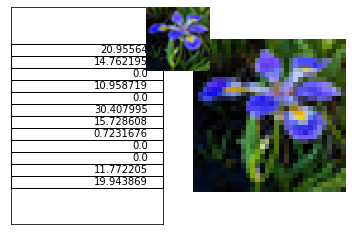

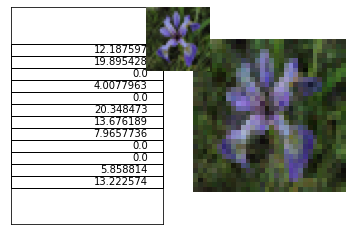

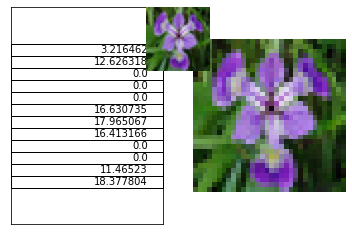

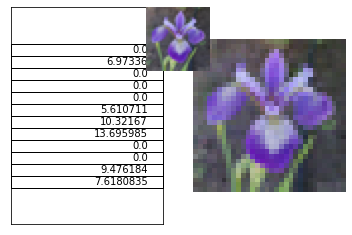

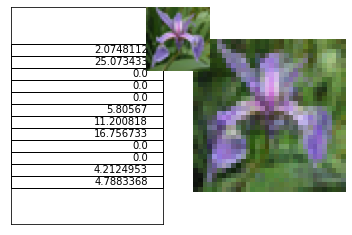

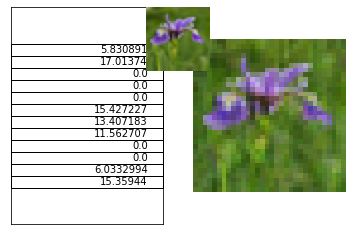

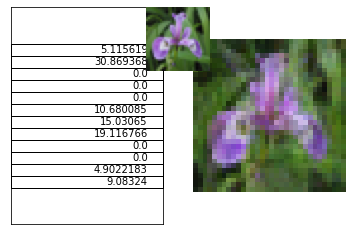

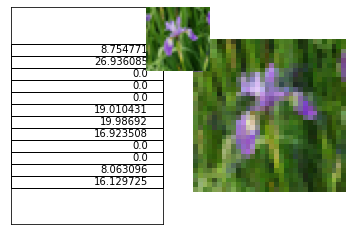

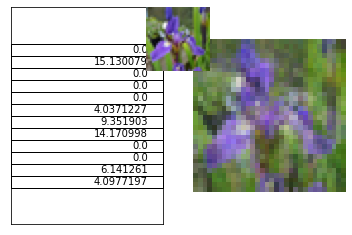

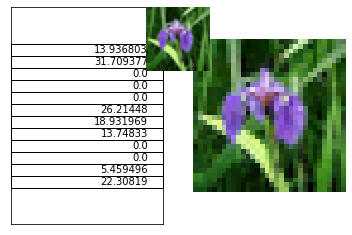

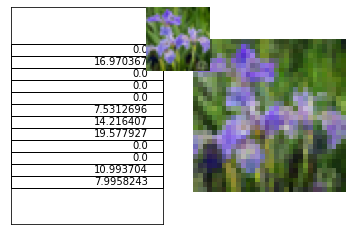

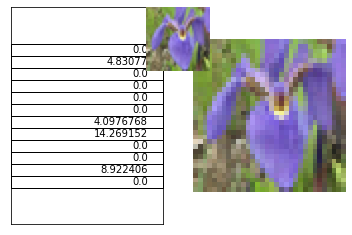

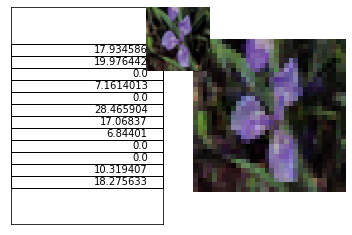

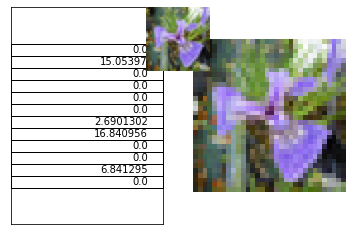

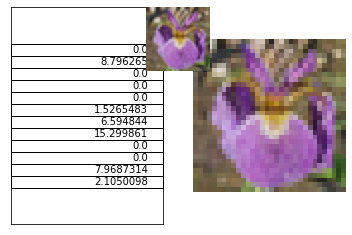

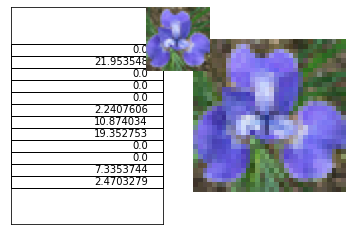

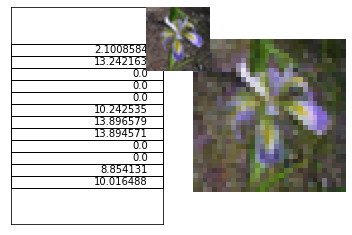

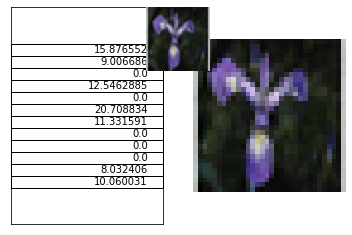

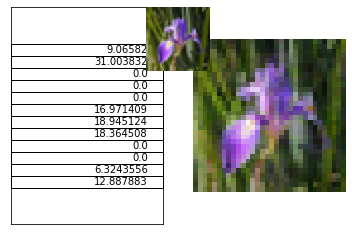

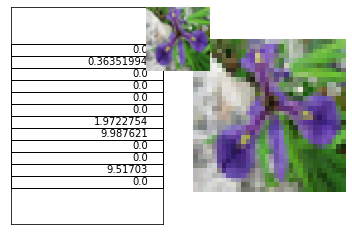

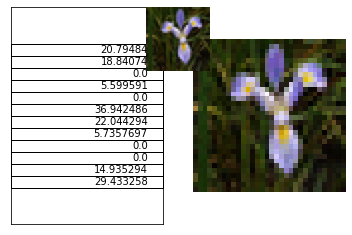

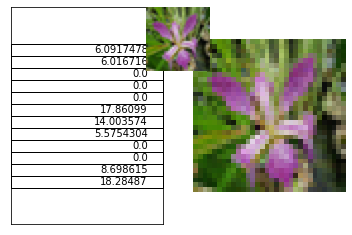

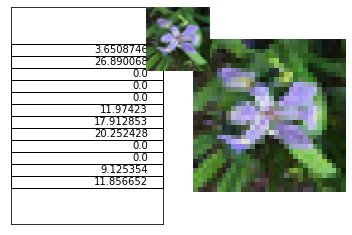

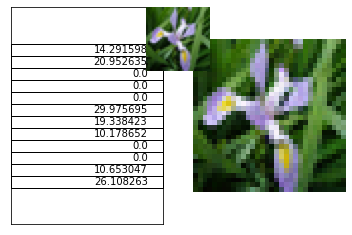

In [15]:
#@title Prueba el modelo Generator usando como entrada los datos de Clustering
pruebaClust = CLUSTmodel.predict( x_train )
pruebaClust_out = GENmodel.predict(  np.array(pruebaClust).reshape((len(pruebaClust), num_features)) )  
 
# muestra las imágenes generadas
print("\n> Resultados (valores de clustering, imagen recounstrida(grande) y original(chica): ")
for i in range(len(x_train)):

    # no muestra las generadas por DA
    if not esDAimag_train[i]:

        fig = plt.figure()

        # muestra los datos
        ax1 = fig.add_subplot(121)
        ax1.table(cellText=pruebaClust[i].reshape(num_features, 1), loc='center')   
        ax1.get_xaxis().set_visible(False)
        ax1.get_yaxis().set_visible(False)  

        #  muestra reconstrucción
        ax2 = fig.add_subplot(122)
        plot_image(pruebaClust_out[i])  

        # muestra imagen original
        ax3 = fig.add_subplot(332)
        plot_image(x_train[i])  

        fig = plt.gcf()